In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples

## Network architecture

We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

In [3]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

## Distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [4]:
x_dim = 2
mu = np.zeros(2,)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])

distribution = Gaussian(mu, cov)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network)

9.999999999999705 float64




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


We can directly sample from this distribution and plot it for sanity-check.

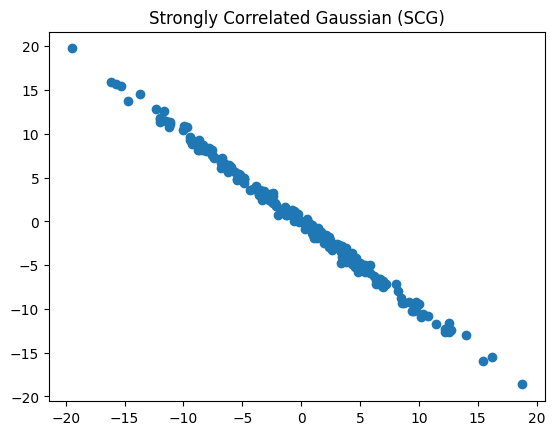

In [5]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

We set up the loss on both $p(\xi)$ (here `x`) and $q(\xi)$ (here `z`). We then train with Adam with a learning rate of $10^{-3}$.

In [6]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

The training loop described in Algorithm $1$.

In [9]:
n_steps = 5000
n_samples = 200

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:        
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))


2023-12-12 11:14:42.860279: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-12-12 11:14:42.927995: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe4ba4947b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-12 11:14:42.928012: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Step: 0 / 5000, Loss: -7.06e+01, Acceptance sample: 0.91, LR: 0.00100
Step: 100 / 5000, Loss: -2.69e+02, Acceptance sample: 0.66, LR: 0.00100
Step: 200 / 5000, Loss: -1.64e+03, Acceptance sample: 0.37, LR: 0.00100
Step: 300 / 5000, Loss: -4.30e+03, Acceptance sample: 0.36, LR: 0.00100
Step: 400 / 5000, Loss: -4.90e+03, Acceptance sample: 0.30, LR: 0.00100
Step: 500 / 5000, Loss: -5.33e+03, Acceptance sample: 0.40, LR: 0.00100
Step: 600 / 5000, Loss: -7.18e+03, Acceptance sample: 0.35, LR: 0.00100
Step: 700 / 5000, Loss: -6.92e+03, Acceptance sample: 0.39, LR: 0.00100
Step: 800 / 5000, Loss: -6.46e+03, Acceptance sample: 0.39, LR: 0.00100
Step: 900 / 5000, Loss: -8.00e+03, Acceptance sample: 0.42, LR: 0.00100
Step: 1000 / 5000, Loss: -7.55e+03, Acceptance sample: 0.36, LR: 0.00096
Step: 1100 / 5000, Loss: -8.32e+03, Acceptance sample: 0.37, LR: 0.00096
Step: 1200 / 5000, Loss: -8.19e+03, Acceptance sample: 0.42, LR: 0.00096
Step: 1300 / 5000, Loss: -9.37e+03, Acceptance sample: 0.36, LR

After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [10]:
samples = distribution.get_samples(n=n_samples)
final_samples = []

for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [11]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [12]:
scale = np.sqrt(np.trace(cov))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

We can plot auto-correlation.

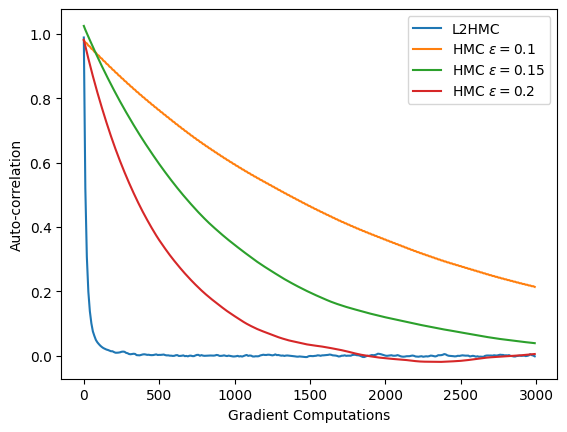

In [13]:
xaxis = 10 * np.arange(300)
plt.plot(xaxis, L2HMC[:300], label='L2HMC')
plt.plot(xaxis, HMC1[:300], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:300], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:300], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [14]:
print ('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

ESS L2HMC: 2.55e-01 -- ESS HMC: 4.82e-03 -- Ratio: 52


We can visualize a single chain of L2HMC for $50$ time steps.

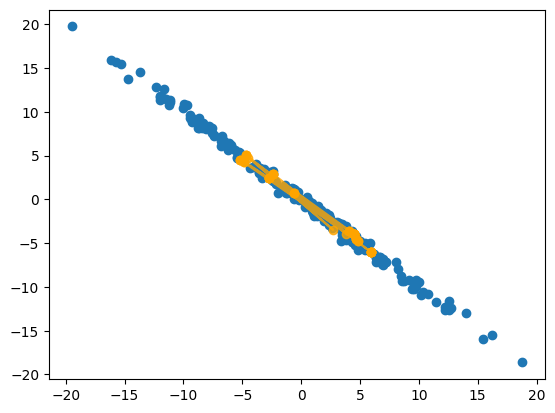

In [15]:
plt.scatter(S[:, 0], S[:, 1])
plt.plot(L2HMC_samples[:50, 1, 0], L2HMC_samples[:50, 1, 1], color='orange', marker='o', alpha=0.8)
plt.show()